# Messing about with ebit fidelity of an optical switch

Below we import the necessary modules

In [1]:
from netsquid.components.switch import Switch
from netsquid.qubits import qubitapi as qapi
from netsquid.components.models.qerrormodels import QuantumErrorModel
from scipy import constants
import netsquid as ns
import numpy as np
import matplotlib.pyplot as plt

## Quantum Error Model

In order to model the switch in the netsquid framework we need to create a quantum error model (see [docs]()). The model describes the noise, loss and visibility impacts on the photons as they traverse the switch and DREH device.

### TODO
- Model quantum error
- Model switch
- Model DREH behaviour
- Recreate John's plots with my construction
- Test on small network
- Clarify assumptions for parameters
- Consult experimentalists on actual values of the switch

In [2]:
class OpticalSwitchErrorModel(QuantumErrorModel):
    """
    Custom error model for the optical switch, applying losses, time delays, and visibility effects.
    """
    def __init__(self, path_diff_matrix, losses_matrix, visibility_matrix, **kwargs):
        super().__init__(**kwargs)
        self.path_diff_matrix = path_diff_matrix
        self.losses_matrix = losses_matrix
        self.visibility_matrix = visibility_matrix

    def error_operation(self, qubits, delta_time=0, **kwargs):
        """
        Apply the loss, time delay, and visibility effects to qubits.
        """
        input_port_a = kwargs.get('input_port_a')
        output_port_a = kwargs.get('output_port_a')
        input_port_b = kwargs.get('input_port_b')
        output_port_b = kwargs.get('output_port_b')

        input_idx_a = int(input_port_a[-1])
        output_idx_a = int(output_port_a[-1])
        input_idx_b = int(input_port_b[-1])
        output_idx_b = int(output_port_b[-1])

        # Apply loss for both qubits A and B
        self.apply_loss(qubits[0], input_idx_a, output_idx_a)
        self.apply_loss(qubits[1], input_idx_b, output_idx_b)

        # Apply time delay for qubits A and B based on path difference
        delta_time_a = self.get_time_delay(input_idx_a, output_idx_a)
        delta_time_b = self.get_time_delay(input_idx_b, output_idx_b)
        delta_time += max(delta_time_a, delta_time_b)  # Apply the larger delay to the simulation time

        # Apply visibility effect between the qubits
        visibility = self.visibility_matrix[input_idx_a][output_idx_b]
        self.apply_visibility(qubits, visibility)

    def apply_loss(self, qubit, input_idx, output_idx):
        """
        Apply loss based on the losses matrix.
        """
        loss_prob = 1 - self.losses_matrix[input_idx][output_idx]
        if np.random.rand() > loss_prob:
            ns.qubits.discard(qubit)

    def get_time_delay(self, input_idx, output_idx):
        """
        Calculate the time delay based on the path length differences and speed of light.
        """
        path_length_diff = self.path_diff_matrix[input_idx][output_idx]
        time_delay = path_length_diff / 3e8  # Time delay = path difference / speed of light (C)
        return time_delay

    def apply_visibility(self, qubits, visibility):
        """
        Adjust the qubits' state based on the HOM visibility.
        """
        # Example: Implement visibility-based operations that affect entanglement
        # This could involve applying a noise model, depolarizing, or reducing fidelity
        for qubit in qubits:
            # Modify qubits according to visibility
            pass

In [10]:
class OpticalSwitch(Switch):
    def __init__(self, name: str = "OpticalSwitch") -> None:
        """
        Custom 3x3 optical switch subclassing the Switch interface in NetSquid.
        """
        super().__init__(name=name)

        # Path length difference matrix (in meters)
        self.path_diff_matrix = np.array([
            [0, -1.69e-3, -2.56e-3], # [P33 - P33, P33 - P32, P33 - P31]
            [1.69e-3, 0, -0.87e-3],  # Path length differences from P32
            [2.56e-3, 0.87e-3, 0]   # Path length differences from P33
        ], dtype='float32')

        # Loss matrix (transmissivity) based on provided dB loss values
        self.losses_matrix = [
            [self.dB_to_transmissivity(1.319), self.dB_to_transmissivity(2.12), self.dB_to_transmissivity(2.005)],
            [self.dB_to_transmissivity(2.12), self.dB_to_transmissivity(1.319), self.dB_to_transmissivity(2.12)],
            [self.dB_to_transmissivity(2.005), self.dB_to_transmissivity(2.12), self.dB_to_transmissivity(1.319)]
        ]

        # Visibility values
        self.visibility_matrix = [
            [0, 0.9891036205398629, 0.9947078063661267],
            [0.9891036205398629, 0, 0.9979755184580268],
            [0.9947078063661267, 0.9979755184580268, 0]
        ]

        # Add 3 input and 3 output ports
        self.add_ports(['in0', 'in1', 'in2', 'out0', 'out1', 'out2'])

    def get_path_diff(self, input_port_a: str, output_port_a: str, input_port_b: str, output_port_b: str) -> float:
        """
        Get the path difference for photons A and B traversing the switch.

        :param input_port_a: Input port name for photon A (e.g., 'in0', 'in1', 'in2').
        :param output_port_a: Output port name for photon A (e.g., 'out0', 'out1', 'out2').
        :param input_port_b: Input port name for photon B (e.g., 'in0', 'in1', 'in2').
        :param output_port_b: Output port name for photon B (e.g., 'out0', 'out1', 'out2').
        :return: Path difference for photons A and B.
        """
        a_idx_delta = abs(int(input_port_a[-1]) - int(output_port_a[-1]))
        b_idx_delta = abs(int(input_port_b[-1]) - int(output_port_b[-1]))

        return self.path_diff_matrix[a_idx_delta][b_idx_delta]

    def apply_loss(self, input_port: str, output_port: str) -> float:
        """
        Apply loss based on the path losses between input and output ports.

        :param input_port: Input port name (e.g., 'in0', 'in1', 'in2').
        :param output_port: Output port name (e.g., 'out0', 'out1', 'out2').
        :return: Loss fraction (0 = no loss, 1 = full loss).
        """
        input_idx = int(input_port[-1])
        output_idx = int(output_port[-1])
        return self.losses_matrix[input_idx][output_idx]

    @staticmethod
    def dB_to_transmissivity(loss_dB: float) -> float:
        """
        Convert dB loss to transmissivity (fractional value between 0 and 1).

        :param loss_dB: Loss in dB.
        :return: Transmissivity as a fractional value.
        """
        return pow(10, -loss_dB / 10)

    @staticmethod
    def build_density_matrix(nu_a: float, nu_b: float, nu_d: float, p_d: float, v: float, m: int) -> np.ndarray:
        """
        Build the dual density matrix.

        :param nu_a: Photon A channel transmission loss.
        :param nu_b: Photon B channel transmission loss.
        :param nu_d: Detection efficiency of photon detectors.
        :param p_d: Total excess noise (photons per qubit slot) in photon detectors.
        :param v: Visibility parameter.
        :param m: Click pattern parity bit (0 for [0, 1, 1, 0] or [1, 0, 0, 1]; 1 for [1, 1, 0, 0] or [0, 0, 1, 1]).
        :return: A 4x4 NumPy array representing the dual density matrix.
        """
        d_01 = nu_a * nu_b * pow(nu_d, 2) / 4
        d_03 = pow(-1, m) * d_01 * abs(pow(v, 2))
        d_11 = 0.5 * (1 - p_d) * nu_d * (nu_a + nu_b - 2 * nu_a * nu_b * nu_d) + p_d * (1 - nu_a * nu_d) * (1 - nu_b * nu_d)
        n_d = 2 * pow(1 - p_d, 4) * d_01 + 4 * p_d * pow(1 - p_d, 2) * d_11

        rho_dual = (pow(1 - p_d, 4) / n_d) * np.array([[0, 0, 0, 0],
                                                      [0, d_01, d_03, 0],
                                                      [0, d_03, d_01, 0],
                                                      [0, 0, 0, 0]], dtype='float64') + \
                   (p_d * pow(1 - p_d, 2) / n_d) * d_11 * np.identity(4, dtype='float64')

        return rho_dual

    @staticmethod
    def calculate_fidelity(rho_dual: np.ndarray) -> float:
        """
        Calculate the fidelity of the ebit generated via the dual-rail entanglement protocol.

        :param rho_dual: 4x4 NumPy array representing the dual density matrix.
        :return: Fidelity of the ebit generated.
        """
        N = np.sum(np.diag(rho_dual))  # Normalization factor
        fidelity = (rho_dual[1, 1] + rho_dual[2, 2] + 2 * rho_dual[1, 2]) / (2 * N)
        return fidelity

    @staticmethod
    def return_visibility(relative_distance: float, FWHM_in_seconds: float, central_wav_a: float, central_wav_b: float) -> float:
        """
        Calculate the HOM visibility based on path length differences and FWHM.

        :param relative_distance: Relative path difference between two photons (in meters).
        :param FWHM_in_seconds: Full width half maximum (FWHM) of the photon pulse (in seconds).
        :param central_wav_a: Central wavelength of photon A (in nm).
        :param central_wav_b: Central wavelength of photon B (in nm).
        :return: HOM visibility (v ∈ [0, 1]).
        """
        t = relative_distance / constants.c  # Time delay based on relative distance and speed of light

        # Spectral width derived from FWHM
        spectral_width_a = 2 * np.sqrt(np.log(2)) / FWHM_in_seconds
        spectral_width_b = 2 * np.sqrt(np.log(2)) / FWHM_in_seconds

        # Central frequency from central wavelength
        central_frequency_a = constants.c / (central_wav_a * 1e-9)
        central_frequency_b = constants.c / (central_wav_b * 1e-9)

        # Visibility calculation
        numerator = -1 * ((spectral_width_a**2) * (spectral_width_b**2) * (t**2) + (central_frequency_a - central_frequency_b)**2)
        denominator = (spectral_width_a**2 + spectral_width_b**2)
        v = (2 * spectral_width_a * spectral_width_b) / denominator * np.exp(numerator / denominator)

        return v

Testing routing

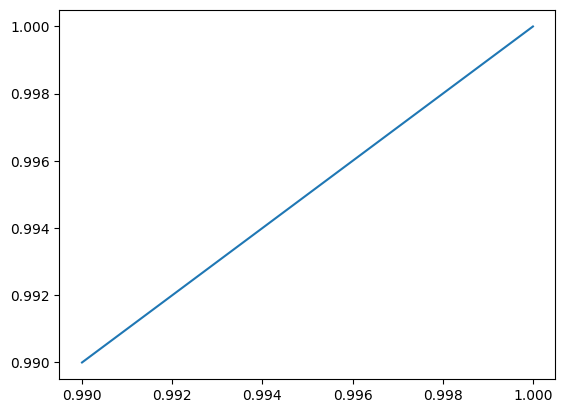

In [11]:
visibility_vals = np.arange(0.99, 1, 0.0001)
visibility = np.empty(visibility_vals.size, dtype='float64')

for v in visibility_vals:
    rho_dual = OpticalSwitch.build_density_matrix(nu_a = 1, nu_b = 1, nu_d = 1, p_d = 0, v = v, m = 0)
    fidelity = OpticalSwitch.calculate_fidelity(rho_dual)

plt.plot(visibility_vals, visibility)